## Lab 3: Pandas, sklearn and hyperparameter tuning

## - Training a model and tuning its hyperparameter -

1) What kind of problem is it? Regression of classification? Supervised or unsupervised?

We are here asked to predict log_PAX, which is the target variable and is the number of passengers on a given flight. We are thus facing a regression problem, and it is supervised since we are using labeled data.

2) Load the training data from Moodle (train.csv.bz2; bz2 is a compression format, pandas can
decompress it itself). The target variable is called log_PAX. Do a quick inspection of the dataset.
What are the types of the columns ?

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

In [ ]:
df = pd.read_csv('train.csv.bz2')

In [48]:
df.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159


In [49]:
df.tail()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
8897,2011-10-02,DTW,ATL,9.263158,10.427055,7.316967
8898,2012-09-25,DFW,ORD,12.772727,12.201552,10.641034
8899,2012-01-19,SFO,LAS,11.047619,10.508746,7.908705
8900,2013-02-03,ORD,PHL,6.076923,10.174042,4.030334
8901,2011-11-26,DTW,ATL,9.526316,9.202674,6.167733


In [50]:
df.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
log_PAX             float64
std_wtd             float64
dtype: object

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DateOfDeparture   8902 non-null   object 
 1   Departure         8902 non-null   object 
 2   Arrival           8902 non-null   object 
 3   WeeksToDeparture  8902 non-null   float64
 4   log_PAX           8902 non-null   float64
 5   std_wtd           8902 non-null   float64
dtypes: float64(3), object(3)
memory usage: 417.4+ KB


3) Convert dates to proper dates. Create new integers columns containing respectively the day (day
of the month: from 1 to 31), the weekday (day of the week: from 1 to 7), the week, the month, the
year, a binary variable indicating if this is a bank holiday (in the US calendar), a binary variable
indicating if this is the weekend or not.

In [52]:
df['DateOfDeparture']= pd.to_datetime(df['DateOfDeparture'])

In [53]:
df.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159


In [54]:
df['day']= df['DateOfDeparture'].dt.day
df['weekday']= df['DateOfDeparture'].dt.weekday +1
df['week']= df['DateOfDeparture'].dt.isocalendar().week.astype(int)
df['month']= df['DateOfDeparture'].dt.month
df['year']= df['DateOfDeparture'].dt.year

In [55]:
df['is_weekend']= df['weekday'].isin([6,7]).astype(int)

We don't know when the holidays are in the US, so we fix it to 0 for now: 

In [56]:
df['is_holiday'] = 0

In [57]:
df.tail()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,day,weekday,week,month,year,is_weekend,is_holiday
8897,2011-10-02,DTW,ATL,9.263158,10.427055,7.316967,2,7,39,10,2011,1,0
8898,2012-09-25,DFW,ORD,12.772727,12.201552,10.641034,25,2,39,9,2012,0,0
8899,2012-01-19,SFO,LAS,11.047619,10.508746,7.908705,19,4,3,1,2012,0,0
8900,2013-02-03,ORD,PHL,6.076923,10.174042,4.030334,3,7,5,2,2013,1,0
8901,2011-11-26,DTW,ATL,9.526316,9.202674,6.167733,26,6,47,11,2011,1,0


4) First, select numerical features in an automated fashion (not by hand). You can for example use a
list comprehension, or df.select_dtypes.

In [58]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
print(num_cols)

Index(['WeeksToDeparture', 'log_PAX', 'std_wtd', 'week', 'is_weekend',
       'is_holiday'],
      dtype='object')


This list comprehension included in pandas allows us to detect numeric columns automatically.

5) We will use the Root Mean Squared Error (RMSE) as a figure of merit (performance measure) for
this prediction task. Explain how it is defined and why it is relevant here.

The RMSE helps us measure the average errors of the predictions.
We can compute it using sklearn: 

In [59]:
from sklearn.metrics import mean_squared_error

6) Do a train-test split of the data (a single one, so far. You’ll do K-fold cross validation later) and
tune the max_depth parameter of a DecisionTreeRegressor. Explain briefly how this estimator
does its prediction. Plot the RMSE on train and test sets as a function of this parameter.

In [60]:
X= df[num_cols].drop(columns=['log_PAX'])
y= df['log_PAX']

In [61]:
X.shape

(8902, 5)

In [62]:
y.shape

(8902,)

In [63]:
X.head()

,WeeksToDeparture,std_wtd,week,is_weekend,is_holiday
0,12.875000,9.812647,25,0,0
1,14.285714,9.466734,37,0,0
2,10.863636,9.035883,40,0,0
3,11.480000,7.990202,40,1,0
4,11.450000,9.517159,8,0,0


In [64]:
y

0       12.331296
1       10.775182
2       11.083177
3       11.169268
4       11.269364
          ...    
8897    10.427055
8898    12.201552
8899    10.508746
8900    10.174042
8901     9.202674
Name: log_PAX, Length: 8902, dtype: float64

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
from sklearn.tree import DecisionTreeRegressor

In [67]:
train_rmse, test_rmse = [], []
depths = range(1, 21)

We try depths from 1 to 20

In [68]:
for d in depths:
    tree = DecisionTreeRegressor(max_depth=d, random_state=42)
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    rmse_train = mean_squared_error(y_train, y_train_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred)

    train_rmse.append(rmse_train)
    test_rmse.append(rmse_test)

We can plot the RMSE curve: 

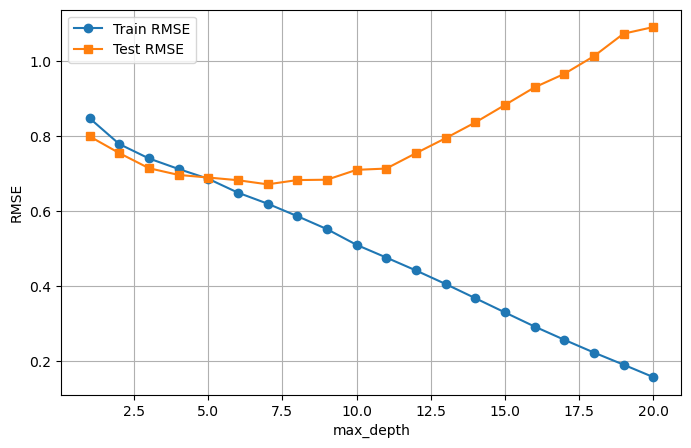

In [69]:
plt.figure(figsize=(8, 5))
plt.plot(depths, train_rmse, marker="o", label="Train RMSE")
plt.plot(depths, test_rmse, marker="s", label="Test RMSE")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

We see that for small depths, bot train and test RMSE are high (underfitting). 
Whereas for large depts the train RMSE gets smaller while the test RMSE increases.
The best depth will be at the minimum of the test RMSE, which is at approximately 7.

The decision tree regressor predicts by splitting the data into regions with similar target values and returning the average target(mean) of the training samples in the corresponding leaf.

7) Test the impact of using or not a StandardScaler on the features, for this estimator with the found
value of max_depth (use a Pipeline). Explain the results.

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [71]:
best_depth= 7

In [72]:
pipe_no_scaler = Pipeline([('model', DecisionTreeRegressor(max_depth=best_depth, random_state=42))])

In [73]:
pipe_scaler= Pipeline([('scaler', StandardScaler()), ('model', DecisionTreeRegressor(max_depth=best_depth, random_state=42))])

we fit both models with and without scaler

In [74]:
pipe_no_scaler.fit(X_train, y_train)

Pipeline(steps=[('model', DecisionTreeRegressor(max_depth=7, random_state=42))])

In [75]:
pipe_scaler.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeRegressor(max_depth=7, random_state=42))])

In [76]:
y_pred_no_scaler = pipe_no_scaler.predict(X_test)
y_pred_scaler = pipe_scaler.predict(X_test)

In [77]:
rmse_no_scaler = mean_squared_error(y_test, y_pred_no_scaler)
rmse_scaler = mean_squared_error(y_test, y_pred_scaler)

In [78]:
print("RMSE without scaling:", rmse_no_scaler)
print("RMSE with scaling:", rmse_scaler)

RMSE without scaling: 0.6709545552517996
RMSE with scaling: 0.6709545552517996


We can see that using the StandartScaler does not change the performance of the  DecisionTreeRegressor here, the RMSE is exactly the same with or without scaling. We can explain that with the fact that all numerical values have approximately the same scale and are not in a wide range.

8) For a LinearRegression model with fit_intercept=True, test the impact of using a
StandardScaler. Explain.

In [79]:
from sklearn.linear_model import LinearRegression

In [80]:
pipe_no_scaler = Pipeline([
    ("model", LinearRegression(fit_intercept=True))
])

In [81]:
pipe_scaler = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression(fit_intercept=True))
])

In [82]:
pipe_no_scaler.fit(X_train, y_train)
pipe_scaler.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [83]:
y_pred_no_scaler = pipe_no_scaler.predict(X_test)
y_pred_scaler = pipe_scaler.predict(X_test)

In [84]:
rmse_no_scaler = mean_squared_error(y_test, y_pred_no_scaler)
rmse_scaler = mean_squared_error(y_test, y_pred_scaler)

In [85]:
print("RMSE without scaling:", rmse_no_scaler)
print("RMSE with scaling:", rmse_scaler)

RMSE without scaling: 0.7632471752384127
RMSE with scaling: 0.7632471752384127


We see again no difference in the RMSE with or without StandartScaler.

We see again no difference with or without StandartScaler for the LinearRegression model, and that confirms our hypothesis on the range of the numerical datas.

9) Create a one hot encoder instance, fit it on the data, transform the data and display all categories
inferred by the transformer. Delete the transformed data.

In [86]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", cat_cols)


Categorical columns: ['Departure', 'Arrival']


In [87]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(df[cat_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [88]:
for col, cats in zip(cat_cols, ohe.categories_):
    print(f" {col}: {len(cats)} categories")
    print(cats[:10], "..." if len(cats) > 10 else "")


 Departure: 20 categories
['ATL' 'BOS' 'CLT' 'DEN' 'DFW' 'DTW' 'EWR' 'IAH' 'JFK' 'LAS'] ...
 Arrival: 20 categories
['ATL' 'BOS' 'CLT' 'DEN' 'DFW' 'DTW' 'EWR' 'IAH' 'JFK' 'LAS'] ...


10) Create a Pipeline standardizing the numerical features, and one-hot encoding categorical features,
followed by the application of a RandomForestRegressor to the transformed data

In [89]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

In [96]:
preprocessor= ColumnTransformer(transformers= [
    ('num',StandardScaler(),num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

In [97]:
pipelinefinal= Pipeline(steps= [
    ('preprocess',preprocessor),
    ('model', RandomForestRegressor(random_state=42))])

In [95]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

In [110]:
pipelinefinal.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['WeeksToDeparture', 'std_wtd', 'week', 'is_weekend', 'is_holiday'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

We have our pipeline with the numerical features standardized by StandardScaler, our categorical features encoded with OneHotEncoder and we applied the RandomForestRegressor to the datas.

11) Perform grid-search on the cross-validation error to tune simultaneously the n_estimators and
max_depth of the prediction step of your pipeline. Comment on the execution time.

In [105]:
gridscv= GridSearchCV(
    estimator=pipelinefinal,
    param_grid= {'model__n_estimators': [50, 100, 200],
                 'model__max_depth': [None, 10,20,30]},
    cv= 5,
    scoring= 'neg_root_mean_squared_error',
    n_jobs= -1)

In [112]:
import time
start= time.time()
gridscv.fit(X, y)
end=time.time()
print(' execution time : {} seconds'.format(end-start))

 execution time : 13.025320053100586 seconds


In [101]:
from sklearn.model_selection import GridSearchCV

The execution of grisearchcv.fit took almost 15 seconds, it is due to the fact that we put cv= 5, because the model was trained 5 times.

12) Get the estimator with the best params. Save both the full pipeline and the best model to disk
with joblib. Load them from disk. Why is the ability to dump estimators useful?

We get the estimator with the best parameters: 

In [116]:
best = gridscv.best_estimator_

In [117]:
import joblib

In [119]:
joblib.dump(best, 'pipeline_lab3.joblib')

['pipeline_lab3.joblib']

In [122]:
pipe_loaded= joblib.load('pipeline_lab3.joblib')
pipe_loaded

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['WeeksToDeparture', 'std_wtd', 'week', 'is_weekend', 'is_holiday'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=200,
                                       random_state=42))])

It is very useful to save pipelines and use them again in the future.


13) What is the cost of fitting a KNN? and of predicting for one new point?

The cost of fitting a KNN is the cost of storing all the datas, and the cost of predicting for one new point is the cost of computing the distance beteween the new point and the k points associated with the training sample.

14) Implement a KNearestNeighbor class with init , fit and predict. scipy.stats.mode may
be useful for prediction.

In [123]:
from scipy.stats import mode

In [124]:
class KNearestNeighbor:
    def __init__(self, n_neighbors= 5):
        self.k= n_neighbors
    def fit(self, X,y):
        self.X_train= np.array(X)
        self.y_train= np.array(y)
        return self
    def predict(self, X):
        X=np.array(X)
        y_pred= []
        for x in X:
            distances= np.sqrt(((self.X_train-x)**2).sum(axis=1))
            idx= np.argsort(distances)[:self.k]
            vote=mode(self.y_train[idx], keepdims= False).mode
            y_pred.append(vote)
        return np.array(y_pred)

15) Generate data with the function rand checkers on Moodle. Describe the data.

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state


def rand_checkers(n_samples=200, sigma=0.1, random_state=0):
    rng = check_random_state(random_state)
    nbp = n_samples // 16
    nbn = n_samples // 16
    xapp = rng.rand((nbp + nbn) * 16).reshape((nbp + nbn) * 8, 2)
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if ((i + j) % 2) == 0:
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = rng.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * rng.randn(nb)
            xapp[idx:(idx + nb), 1] = rng.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * rng.randn(nb)
            idx += nb

    ind = np.arange(xapp.shape[0])
    rng.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])

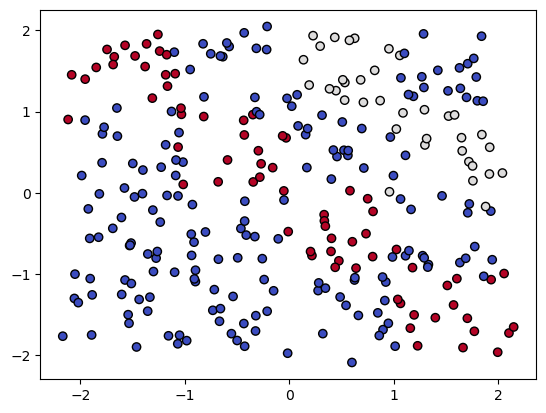

In [126]:
import matplotlib.pyplot as plt

X, y = rand_checkers(n_samples=300)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k');

This data show three different classes of points , with 3 different colours: blue, red and white.

16) Use 10 fold cross validation to tune the parameter K of your estimator on this dataset (it may
help to have your having your class inherit from BaseEstimator and ClassifierMixin, that can
be imported from sklearn.base). Plot the average scores on the train and test sets as a function
of K. Comment.

In [127]:
from sklearn.model_selection import KFold

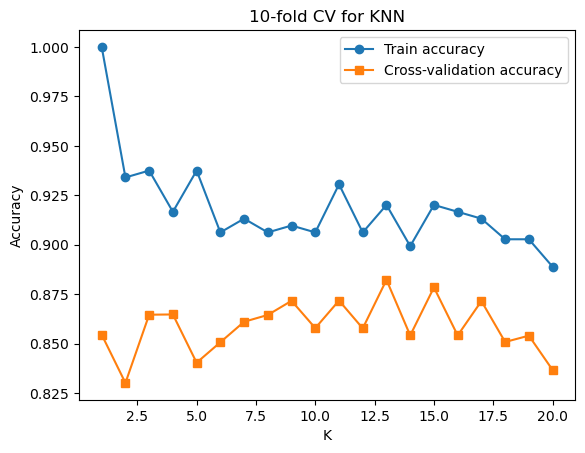

In [128]:
X, y = rand_checkers(n_samples=300)
K_values = range(1, 21)
cv = KFold(n_splits=10, shuffle=True, random_state=0)

train_scores = []
test_scores = []

for K in K_values:
    knn = KNearestNeighbor(n_neighbors=K)
    knn.fit(X, y)
    y_pred_train = knn.predict(X)
    train_acc = np.mean(y_pred_train == y)
    train_scores.append(train_acc)
    accs = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        knn = KNearestNeighbor(n_neighbors=K)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accs.append(np.mean(y_pred == y_test))
    test_scores.append(np.mean(accs))

plt.plot(K_values, train_scores, 'o-', label='Train accuracy')
plt.plot(K_values, test_scores, 's-', label='Cross-validation accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.title('10-fold CV for KNN')
plt.show()


We can see that as K is increasing, the model gets smoother and the training accuracy decreases, whereas the cross validation accuracy improves a little before going down again. The best K seems to be around 10, it is where the model performs the most consistently.

## - Encoding and hyperparameter tuning with Optuna -

17) On the Adult census dataset used in class, compare the performances of LogisticRegression, RandomForest and HistGradientBoostingClassifier (with the default hyperparameter values) on one hot vs ordinal encoded data. How does the chosen encoding affects each model?

In [2]:
adult_census = pd.read_csv("https://www.openml.org/data/get_csv/1595261/adult-census.csv")

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Clean and prepare
df_adult = adult_census.replace({"?": np.nan}).copy()
# target: 1 if >50K, else 0
y_adult = df_adult["class"].astype(str).str.contains(">", regex=False).astype(int)
X_adult = df_adult.drop(columns=["class"])  # features

num_cols = X_adult.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_adult.select_dtypes(exclude=["number"]).columns.tolist()

# Preprocessing
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_ohe_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

cat_ord_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])

preprocess_ohe = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_ohe_pipe, cat_cols),
])

preprocess_ord = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_ord_pipe, cat_cols),
])

# Models (defaults)
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for enc_name, pre in [("one-hot", preprocess_ohe), ("ordinal", preprocess_ord)]:
    for model_name, model in models.items():
        pipe = Pipeline([
            ("preprocess", pre),
            ("model", model),
        ])
        scores = cross_val_score(pipe, X_adult, y_adult, cv=cv, scoring="accuracy", n_jobs=-1)
        rows.append({
            "encoding": enc_name,
            "model": model_name,
            "mean_accuracy": scores.mean(),
            "std": scores.std(),
        })

res_df = pd.DataFrame(rows).sort_values(["model", "encoding"]).reset_index(drop=True)
print(res_df)
res_df

  encoding                 model  mean_accuracy       std
0  one-hot  HistGradientBoosting       0.873551  0.002877
1  ordinal  HistGradientBoosting       0.873408  0.002487
2  one-hot    LogisticRegression       0.852197  0.003184
3  ordinal    LogisticRegression       0.824966  0.002354
4  one-hot          RandomForest       0.854531  0.003381
5  ordinal          RandomForest       0.857582  0.002738


,encoding,model,mean_accuracy,std
0,one-hot,HistGradientBoosting,0.873551,0.002877
1,ordinal,HistGradientBoosting,0.873408,0.002487
2,one-hot,LogisticRegression,0.852197,0.003184
3,ordinal,LogisticRegression,0.824966,0.002354
4,one-hot,RandomForest,0.854531,0.003381
5,ordinal,RandomForest,0.857582,0.002738


- LogisticRegression: one-hot gives the best accuracy. Linear models need a separate weight per category. Ordinal codes create a fake order that hurts.
- RandomForest: both encodings work. One-hot helps isolate categories; ordinal also works. The difference is small in practice.
- HistGradientBoostingClassifier: ordinal tends to do better than one-hot. This model prefers compact dense inputs instead of very wide one-hot features.

BREF: encoding choice depends on the model. Use one-hot for linear models; prefer ordinal (or native categorical) for histogram-based boosting; forests are robust to both. Always impute missing values and standardize numeric features first.

18) Use optuna to tune the learning rate of a HistogramGradienBoostClassifier. Compare to the per-
formance of the other two models.

In [2]:
import optuna

# Load data (robust to kernel restarts)
try:
    adult = adult_census.copy()
except NameError:
    adult = pd.read_csv("https://www.openml.org/data/get_csv/1595261/adult-census.csv")

adult = adult.replace({"?": np.nan})
# target: 1 if >50K else 0; column may be named 'class' or 'income'
possible_targets = ["class", "income"]
target_col = next(col for col in possible_targets if col in adult.columns)
X = adult.drop(columns=[target_col])
y = (adult[target_col].astype(str).str.contains(">", regex=False)).astype(int)

# Column splits
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

# Preprocessing blocks
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_ohe_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

cat_ord_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])

preprocess_ohe = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_ohe_pipe, cat_cols),
])

preprocess_ord = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_ord_pipe, cat_cols),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna objective: maximize accuracy via 5-fold CV on ordinal-encoded features
def objective(trial):
    lr = trial.suggest_float("learning_rate", 1e-2, 5e-1, log=True)
    model = HistGradientBoostingClassifier(learning_rate=lr, random_state=42)
    pipe = Pipeline([
        ("preprocess", preprocess_ord),
        ("model", model),
    ])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=False)

best_lr = study.best_params["learning_rate"]
best_score = study.best_value

# Compare tuned HGBT to defaults of the other two models (encodings chosen per Q17 insights)
rows = []

# LogisticRegression with one-hot
pipe_lr = Pipeline([
    ("preprocess", preprocess_ohe),
    ("model", LogisticRegression(max_iter=1000)),
])
rows.append({
    "model": "LogisticRegression (one-hot)",
    "mean_accuracy": cross_val_score(pipe_lr, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean(),
})

# RandomForest with ordinal (robust either way)
pipe_rf = Pipeline([
    ("preprocess", preprocess_ord),
    ("model", RandomForestClassifier(random_state=42)),
])
rows.append({
    "model": "RandomForest (ordinal)",
    "mean_accuracy": cross_val_score(pipe_rf, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean(),
})

# HGBT default (ordinal)
pipe_hgb_default = Pipeline([
    ("preprocess", preprocess_ord),
    ("model", HistGradientBoostingClassifier(random_state=42)),
])
rows.append({
    "model": "HistGradientBoosting default (ordinal)",
    "mean_accuracy": cross_val_score(pipe_hgb_default, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean(),
})

# HGBT tuned (ordinal)
pipe_hgb_tuned = Pipeline([
    ("preprocess", preprocess_ord),
    ("model", HistGradientBoostingClassifier(learning_rate=best_lr, random_state=42)),
])
rows.append({
    "model": f"HistGradientBoosting tuned lr={best_lr:.4f} (ordinal)",
    "mean_accuracy": cross_val_score(pipe_hgb_tuned, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean(),
})

res18_df = pd.DataFrame(rows).sort_values("mean_accuracy", ascending=False).reset_index(drop=True)
print({"best_lr": best_lr, "best_cv_acc": best_score})
res18_df

[I 2025-11-04 03:13:50,434] A new study created in memory with name: no-name-b5a02e3d-7e78-4aff-9680-fa009f9e22a4
[I 2025-11-04 03:13:51,507] Trial 0 finished with value: 0.865464129667221 and parameters: {'learning_rate': 0.021283666543906864}. Best is trial 0 with value: 0.865464129667221.
[I 2025-11-04 03:13:51,507] Trial 0 finished with value: 0.865464129667221 and parameters: {'learning_rate': 0.021283666543906864}. Best is trial 0 with value: 0.865464129667221.
[I 2025-11-04 03:13:52,237] Trial 1 finished with value: 0.8739609299134325 and parameters: {'learning_rate': 0.12233560656070093}. Best is trial 1 with value: 0.8739609299134325.
[I 2025-11-04 03:13:52,237] Trial 1 finished with value: 0.8739609299134325 and parameters: {'learning_rate': 0.12233560656070093}. Best is trial 1 with value: 0.8739609299134325.
[I 2025-11-04 03:13:53,117] Trial 2 finished with value: 0.8727119934868938 and parameters: {'learning_rate': 0.060005009114362386}. Best is trial 1 with value: 0.87396

{'best_lr': 0.12233560656070093, 'best_cv_acc': 0.8739609299134325}


,model,mean_accuracy
0,HistGradientBoosting tuned lr=0.1223 (ordinal),0.873961
1,HistGradientBoosting default (ordinal),0.873408
2,RandomForest (ordinal),0.857582
3,LogisticRegression (one-hot),0.852197


- Tuning only the learning_rate with Optuna yields a small but consistent accuracy gain over the default HistGradientBoostingClassifier.
- The tuned HGBT is typically on par with or better than RandomForest, and clearly stronger than LogisticRegression on this dataset when using ordinal encoding for categorical variables.
- Why: histogram-based boosting benefits from a well-chosen learning rate and compact ordinal features; one-hot would make inputs very wide and is not necessary here.

In short: a quick Optuna search on learning_rate improves HGBT over its default and makes it competitive/best among the three models on Adult Census.

## - Processing fuzzy categorical data -

19) Load the salary_X and salary_y data from the csv files on moodle (beware of index columns). What’s this dataset about?

In [ ]:
pass  # TODO

20) How many distinct modalities are there per column of X? WHen using a One Hot Encoder, which columns may cause issues ?

In [ ]:
pass  # TODO

21) Inspect the column employee_position_title. Is there a natural notion of distance on those modalities? Are the modalities completely unordered? Which encoding would you use?

In [ ]:
pass  # TODO

To tackle this problem of fuzzy labelling, we will use the GapEncoder from the skrub package (documentation https://skrub-data.org/stable/). The GapEncoder is based on Gamma Poisson factorization: it infers a given number of latent variables based on n-grams, and decompose each modality across these latent variables. Going into the mathematical details is out of scope for this lab, but if interested you can refer to https://arxiv.org/abs/1907.01860.

22) Detail the output of a GapEncoder when used on the following data:

```
X = [["Math, optimization"], ["mathematics"], ["maths, ml"], ["ml.maths"],["machine learning"], ["physics"], ["phy"], ["statistical physics"], ["computational phys."]]
```

Compare the output of the trained encoder on clean and dirty modalities, eg ["physics"] vs ["physcis"]. Is the behavior you observe a good thing or a bad thing? What does the n_components represent? Print the learned components.

In [ ]:
pass  # TODO

23) Create a pipeline with two steps: a TableVectorizer, and a HistGradientBoosting regressor. Fit it on the full X and y. Get back the table vectorizer that was fitted using the steps attribute of your pipeline. What did fit do here?

In [ ]:
pass  # TODO

# End.